In this notebook, we will generate mock data for the DESY3, KiDS-1000 and HSCDR1 weak lensing samples.

The input power spectra comes from EuclidEmulator2 and the baryon parameters mimic BAHAMAS.

In [1]:
import numpy as np
import pyccl as ccl
import sacc
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import scipy
from cobaya import get_model

In [17]:
import baccoemu

mpk = baccoemu.Matter_powerspectrum(nonlinear_emu_path="../../../codes/NN_emulator_PCA6_0.95_300_400n_paired_comb",
                                    nonlinear_emu_details='details.pickle',
                                    model_name='model.h5')

Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...
Linear emulator loaded in memory.
Loading no-wiggles emulator...
No-wiggles emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.


In [2]:
# Planck15 cosmology
Omega_m = 0.3067
Omega_b = 0.0482
m_nu = 0.06
h = 0.6787
n_s = 0.9701
Omega_nu = m_nu / 93.14 / h**2
sigma8 = 0.8085

# Transform sigma8 into As
cosmo = ccl.Cosmology(Omega_c=Omega_m - Omega_b - Omega_nu, Omega_b=Omega_b, h=h, sigma8=sigma8, n_s=n_s, m_nu=m_nu)
# print(cosmo.sigma8())

As_2 = 2.02E-9
cosmo2 = ccl.Cosmology(Omega_c=Omega_m - Omega_b - Omega_nu, Omega_b=Omega_b, h=h, A_s=As_2, n_s=n_s, m_nu=m_nu)
sigma8_2 = cosmo2.sigma8()
# print(cosmo2.sigma8())

As = As_2 * (sigma8/sigma8_2)**2
cosmoAs = ccl.Cosmology(Omega_c=Omega_m - Omega_b - Omega_nu, Omega_b=Omega_b, h=h, A_s=As, n_s=n_s, m_nu=m_nu)
print(sigma8, cosmoAs.sigma8())
# print("As =", As)


paramsP15 = {
    "Omega_m": Omega_m,
    "Omega_b": Omega_b,
    "m_nu": m_nu,
    "h": h,
    "n_s": n_s,
    "A_sE9": As * 1e9
}

0.8085 0.8084999999999999


In [129]:
# DES+KiDS+HSC BF cosmology (2403.13794)
pkfile = np.load('./BACCOEmu_kmax10_baryonbf.npz', allow_pickle=True)
pkdmo = ccl.Pk2D(a_arr=pkfile['expfactors'], lk_arr=np.log(pkfile['k [1/Mpc]']), pk_arr=np.log(pkfile['Pk GrO [Mpc]^3']), is_logp=True)

cosmopars = dict(pkfile['cosmopars'].tolist())
cosmopars.update({'sigma8_tot': float(pkfile['sigma8 tot'])})
cosmopars['omega_matter'] = cosmopars['omega_cold'] + cosmopars['neutrino_mass'] / 93.14 / cosmopars['hubble']**2
h = cosmopars['hubble']

# Transform sigma8 into As

# Initiate CCL Cosmology
cosmo = ccl.Cosmology(Omega_c=cosmopars['omega_cold'] - cosmopars['omega_baryon'], Omega_b=cosmopars['omega_baryon'],
                      h=cosmopars['hubble'], sigma8=cosmopars['sigma8_tot'], n_s=cosmopars['ns'], m_nu=cosmopars['neutrino_mass'])
sigma8=cosmo['sigma8']
print(sigma8, ccl.sigma8(cosmo))

As_2 = 2.02E-9
cosmo2 = ccl.Cosmology(Omega_c=Omega_m - Omega_b - Omega_nu, Omega_b=Omega_b, h=h, A_s=As_2, n_s=n_s, m_nu=m_nu)
sigma8_2 = cosmo2.sigma8()
# print(cosmo2.sigma8())

As = As_2 * (sigma8/sigma8_2)**2
cosmoAs = ccl.Cosmology(Omega_c=Omega_m - Omega_b - Omega_nu, Omega_b=Omega_b, h=h, A_s=As, n_s=n_s, m_nu=m_nu)
print('Check', sigma8, cosmoAs.sigma8())

# print(cosmo.sigma8())
# print(cosmopars)

paramsBF = {
    "Omega_c": cosmo['Omega_c'],
    "Omega_b": cosmo['Omega_b'],
    "m_nu": cosmopars['neutrino_mass'],
    "h": cosmo['h'],
    "n_s": cosmo['n_s'],
    "A_sE9": As * 1e9
}

1.0315098930310274 1.0315098930310274
Check 1.0315098930310274 1.0315098930310278


In [32]:
# Fit BAHAMAS suppression

def get_a_k_Sk_from_table(pktable_b, pktable_dmo):
    z = np.unique(pktable_b[0])[::-1]
    k = np.unique(pktable_b[1])

    assert np.all(pktable_dmo[0] == pktable_b[0])
    assert np.all(pktable_dmo[1] == pktable_b[1])

    k_arr = []
    Sk_arr = []
    for i, zi in enumerate(z):
        sel_b = pktable_b[0] == zi

        ki = pktable_b[1, sel_b]
        Sk = pktable_b[2, sel_b] / pktable_dmo[2, sel_b]
        
        assert np.all(ki == k)
        Sk_arr.append(Sk)
        
    Sk_arr = np.array(Sk_arr)

    return 1/(1+z), k, Sk_arr

def get_a_k_Pk_from_table(pktable_b):
    z = np.unique(pktable_b[0])[::-1]
    k = np.unique(pktable_b[1])
    
    k_arr = []
    Pk_arr = []
    for i, zi in enumerate(z):
        sel_b = pktable_b[0] == zi

        ki = pktable_b[1, sel_b]
        Pk = pktable_b[2, sel_b]
        
        assert np.all(ki == k)
        Pk_arr.append(Pk)
        
    Pk_arr = np.array(Pk_arr)

    return 1/(1+z), k, Pk_arr


# k [h/Mpc], Pk [Mpc/h^3]
pktable_dmo = np.loadtxt("./baryonic_suppressions_pk/powtable_DMONLY_2fluid_nu0.06_Planck2015_L400N1024.dat", unpack=True, usecols=(0, 1, 2))
pktable_b = np.loadtxt("./baryonic_suppressions_pk/powtable_BAHAMAS_nu0.06_Planck2015.dat", unpack=True, usecols=(0, 1, 2))

# Get baryon boost
a_bahamas, k_bahamas, Sk_bahamas = get_a_k_Sk_from_table(pktable_b, pktable_dmo)

# For fit, only k < 5h/Mpc and a = 1
Sk_tofit = Sk_bahamas[-1, k_bahamas < mpk.emulator['baryon']['k'].max()]
k_tofit = k_bahamas[k_bahamas < mpk.emulator['baryon']['k'].max()]

Initial params: {'M_c': 13.58, 'eta': -0.27, 'beta': -0.33, 'M1_z0_cen': 12.04, 'theta_out': 0.25, 'theta_inn': -0.86, 'M_inn': 13.4}
Optimized bcmpars: {'M_c': 13.30826089558846, 'eta': -0.33034027274073247, 'beta': -0.44235016525364285, 'M1_z0_cen': 9.291265048169171, 'theta_out': 0.22836370803409373, 'theta_inn': -0.7176202459449708, 'M_inn': 13.499999471696377}


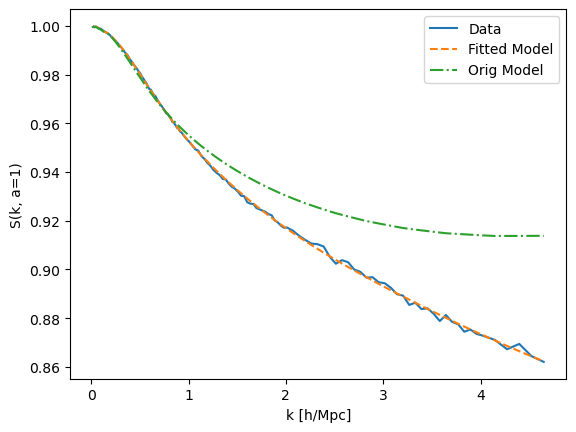

In [120]:
bcmpars = {
        'M_c': 13.58,
        'eta': -0.27,
        'beta': -0.33,
        'M1_z0_cen': 12.04,
        'theta_out': 0.25,
        'theta_inn': -0.86,
        'M_inn': 13.4,
}

def f(k, M_c, eta, beta, M1_z0_cen, theta_out, theta_inn, M_inn):
    _, Skbacco = mpk.get_baryonic_boost(k=k,
                                        omega_matter=paramsP15['Omega_m'],
                                        omega_baryon=paramsP15['Omega_b'],
                                        A_s=paramsP15['A_sE9']*1e-9, 
                                        hubble=paramsP15['h'],
                                        ns=paramsP15['n_s'],
                                        neutrino_mass=paramsP15['m_nu'],
                                        w0=-1, wa=0, expfactor=1,
                                        M_c=M_c,
                                        eta=eta,
                                        beta=beta,
                                        M1_z0_cen=M1_z0_cen,
                                        theta_out=theta_out,
                                        theta_inn=theta_inn,
                                        M_inn=M_inn)
    return Skbacco

def fchi2(x):
    Skbacco = f(k_tofit, *x)
    err = Sk_tofit * 1e-3  # 0.1% rel error
    return np.sum((Skbacco - Sk_tofit)**2/err**2)

fparams = ['M_c', 'eta', 'beta', 'M1_z0_cen', 'theta_out', 'theta_inn', 'M_inn']

p0 = [bcmpars[k] for k in fparams]
bounds_dict = dict( zip(mpk.emulator['baryon']['keys'], mpk.emulator['baryon']['bounds']))
bounds_bcm = np.array([bounds_dict[k] for k in fparams])

# Minimize
out = scipy.optimize.minimize(fchi2, p0, bounds=bounds_bcm, method='Nelder-Mead', tol=1e-6)

M_c_opt, eta_opt, beta_opt, M1_z0_cen_opt, theta_out_opt, theta_inn_opt, M_inn_opt = out.x

# Create a dictionary for the optimized parameters
optimized_bcmpars = {
    'M_c': M_c_opt,
    'eta': eta_opt,
    'beta': beta_opt,
    'M1_z0_cen': M1_z0_cen_opt,
    'theta_out': theta_out_opt,
    'theta_inn': theta_inn_opt,
    'M_inn': M_inn_opt
}

# Print the optimized parameters
print("Initial params:", bcmpars)
print("Optimized bcmpars:", optimized_bcmpars)

# Optionally, plot the fit
Sk_fitted = f(k_tofit, *out.x)
Sk_orig = f(k_tofit, *[bcmpars[k] for k in fparams])

plt.plot(k_tofit, Sk_tofit, label='Data')
plt.plot(k_tofit, Sk_fitted, label='Fitted Model', linestyle='--')
plt.plot(k_tofit, Sk_orig, label='Orig Model', linestyle='-.')

plt.xlabel('k [h/Mpc]')
plt.ylabel('S(k, a=1)')
plt.legend()
plt.show()


bahamas_bcm_params = optimized_bcmpars.copy()

In [141]:
def get_info(model, baryons):
    """
    model: P15 or BF
    baryons: bool, True or False
    """
    
    info = {
        "params": {
            # Commented out to make sure you choose one of the above
        
            # 'A_sE9': 2.02,
            # 'Omega_c': 0.25,
            # 'Omega_b': 0.04,
            # 'h': 0.7,
            # 'n_s': 0.96,
            # 'm_nu': 0.06,
            # 'Omega_m': None,
            # 'sigma8': None,
            # 'S8': None,
            
            # DESY3wl biases
            'bias_DESY3wl__0_m': -0.0063,
            'bias_DESY3wl__1_m': -0.0198,
            'bias_DESY3wl__2_m': -0.0241,
            'bias_DESY3wl__3_m': -0.0369,
            'limber_DESY3wl__0_dz': 0.0,
            'limber_DESY3wl__1_dz': 0.0,
            'limber_DESY3wl__2_dz': 0.0,
            'limber_DESY3wl__3_dz': 0.0,
            'bias_DESY3wl_A_IA': 0.0,
            'limber_DESY3wl_eta_IA': 0.0,
            
            # KiDS1000 biases
            'limber_KiDS1000__0_dz': 0.000,
            'limber_KiDS1000__1_dz': -0.002,
            'limber_KiDS1000__2_dz': -0.013,
            'limber_KiDS1000__3_dz': -0.011,
            'limber_KiDS1000__4_dz': 0.006,
            'bias_KiDS1000__0_m': 0.000,
            'bias_KiDS1000__1_m': 0.000,
            'bias_KiDS1000__2_m': 0.000,
            'bias_KiDS1000__3_m': 0.000,
            'bias_KiDS1000__4_m': 0.000,
            'bias_KiDS1000_A_IA': 0.0,
            'limber_KiDS1000_eta_IA': 0.0,
            
            # HSCDR1wl biases
            'bias_HSCDR1wl__0_m': 0.0,
            'bias_HSCDR1wl__1_m': 0.0,
            'bias_HSCDR1wl__2_m': 0.0,
            'bias_HSCDR1wl__3_m': 0.0,
            'limber_HSCDR1wl__0_dz': 0.0,
            'limber_HSCDR1wl__1_dz': 0.0,
            'limber_HSCDR1wl__2_dz': 0.0,
            'limber_HSCDR1wl__3_dz': 0.0,
            'bias_HSCDR1wl_A_IA': 0.0,
            'limber_HSCDR1wl_eta_IA': 0.0,
            
            # Baryon parameters (Not sure what these are)
            # 'M_c': 13.58,
            # 'eta': -0.27,
            # 'beta': -0.33,
            # 'M1_z0_cen': 12.04,
            # 'theta_out': 0.25,
            # 'theta_inn': -0.86,
            # 'M_inn': 13.4,
        },
        "theory": {
            "cl_like.CCL": {
                "transfer_function": "boltzmann_camb",
                "matter_pk": "halofit",
                "baryons_pk": "nobaryons"
            },
            "cl_like.Pk": {
                "bias_model": "Linear",
                "nonlinear_pk": 'Bacco',
                # baccoemu
                "nonlinear_emu_path": "../../../codes/NN_emulator_PCA6_0.95_300_400n_paired_comb",
                "nonlinear_emu_details": "details.pickle",
                "nonlinear_emu_model_name": "model.h5",
                "zmax_pks": 1.5,
                # baryons
                "use_baryon_boost": baryons,
                "baryon_model": 'Bacco',
                "allow_bcm_emu_extrapolation_for_shear": True,
                "allow_halofit_extrapolation_for_shear": True,
            },
            "cl_like.Limber": {
                "nz_model": "NzShift",
                "ia_model": "IADESY1_PerSurvey",
                "input_params_prefix": "limber"
            },
            "cl_like.ClFinal": {
                "input_params_prefix": "bias",
                "shape_model": "ShapeMultiplicative"
            }
        },
        "likelihood": {
            "cl_like.ClLike": {
                "input_file": "../../../data/cls_DESY3_noK1000_noHSCDR1wl_plus_KiDS1000_noHSCDR1wl_cov_4096_GNG_ee.fits",
                "bins": [
                    {"name": "DESY3wl__0"},
                    {"name": "DESY3wl__1"},
                    {"name": "DESY3wl__2"},
                    {"name": "DESY3wl__3"},
                    {"name": "KiDS1000__0"},
                    {"name": "KiDS1000__1"},
                    {"name": "KiDS1000__2"},
                    {"name": "KiDS1000__3"},
                    {"name": "KiDS1000__4"},
                    {"name": "HSCDR1wl__0"},
                    {"name": "HSCDR1wl__1"},
                    {"name": "HSCDR1wl__2"},
                    {"name": "HSCDR1wl__3"}
                ],
                "twopoints": [
                    {"bins": ["DESY3wl__0", "DESY3wl__0"]},
                    {"bins": ["DESY3wl__0", "DESY3wl__1"]},
                    {"bins": ["DESY3wl__0", "DESY3wl__2"]},
                    {"bins": ["DESY3wl__0", "DESY3wl__3"]},
                    {"bins": ["DESY3wl__1", "DESY3wl__1"]},
                    {"bins": ["DESY3wl__1", "DESY3wl__2"]},
                    {"bins": ["DESY3wl__1", "DESY3wl__3"]},
                    {"bins": ["DESY3wl__2", "DESY3wl__2"]},
                    {"bins": ["DESY3wl__2", "DESY3wl__3"]},
                    {"bins": ["DESY3wl__3", "DESY3wl__3"]},
                    {"bins": ["KiDS1000__0", "KiDS1000__0"]},
                    {"bins": ["KiDS1000__0", "KiDS1000__1"]},
                    {"bins": ["KiDS1000__0", "KiDS1000__2"]},
                    {"bins": ["KiDS1000__0", "KiDS1000__3"]},
                    {"bins": ["KiDS1000__0", "KiDS1000__4"]},
                    {'bins': ['KiDS1000__1', 'KiDS1000__1']},
                    {'bins': ['KiDS1000__1', 'KiDS1000__2']},
                    {'bins': ['KiDS1000__1', 'KiDS1000__3']},
                    {'bins': ['KiDS1000__1', 'KiDS1000__4']},
                    {'bins': ['KiDS1000__2', 'KiDS1000__2']},
                    {'bins': ['KiDS1000__2', 'KiDS1000__3']},
                    {'bins': ['KiDS1000__2', 'KiDS1000__4']},
                    {'bins': ['KiDS1000__3', 'KiDS1000__3']},
                    {'bins': ['KiDS1000__3', 'KiDS1000__4']},
                    {'bins': ['KiDS1000__4', 'KiDS1000__4']},
                    {'bins': ['HSCDR1wl__0', 'HSCDR1wl__0']},
                    {'bins': ['HSCDR1wl__0', 'HSCDR1wl__1']},
                    {'bins': ['HSCDR1wl__0', 'HSCDR1wl__2']},
                    {'bins': ['HSCDR1wl__0', 'HSCDR1wl__3']},
                    {'bins': ['HSCDR1wl__1', 'HSCDR1wl__1']},
                    {'bins': ['HSCDR1wl__1', 'HSCDR1wl__2']},
                    {'bins': ['HSCDR1wl__1', 'HSCDR1wl__3']},
                    {'bins': ['HSCDR1wl__2', 'HSCDR1wl__2']},
                    {'bins': ['HSCDR1wl__2', 'HSCDR1wl__3']},
                    {'bins': ['HSCDR1wl__3', 'HSCDR1wl__3']},
                ],
                "defaults": {
                        'lmax': 8192,
                        'lmin': 0,
                        # 'DESY3wl__0': {'lmin': 20},
                        # 'DESY3wl__1': {'lmin': 20},
                        # 'DESY3wl__2': {'lmin': 20},
                        # 'DESY3wl__3': {'lmin': 20},
                        # 'KiDS1000__0': {'lmin': 100},
                        # 'KiDS1000__1': {'lmin': 100},
                        # 'KiDS1000__2': {'lmin': 100},
                        # 'KiDS1000__3': {'lmin': 100},
                        # 'KiDS1000__4': {'lmin': 100},
                        # 'HSCDR1wl__0': {'lmin': 300},
                        # 'HSCDR1wl__1': {'lmin': 300},
                        # 'HSCDR1wl__2': {'lmin': 300},
                        # 'HSCDR1wl__3': {'lmin': 300},
                    },
            }
        },
     "debug": False
    }
    
    # Planck 15
    if model == 'P15':
        info['params'].update(paramsP15)
    elif model == 'BF':
        info['params'].update(paramsBF)
    else:
        raise ValueError("Model not implemented. Choose 'P18' or 'BF'")

    if baryons:
        info['params'].update(bahamas_bcm_params)
    
    return info

infoP15 = get_info('P15', True)
infoBF = get_info('BF', True)
infoP15_GrO = get_info('P15', False)
infoBF_GrO = get_info('BF', False)

print(infoBF["params"]["Omega_b"], infoP15["params"]["Omega_b"])

0.051375726 0.0482


In [142]:
# Get model and generate a mock data vector

for cosmology in ['P15', 'BF']:
    for nonlin in ['GrO', 'Baryons']:
        if nonlin == 'GrO':
            baryons = False
        else:
            baryons = True
            nonlin += 'BAHAMAS'
            
        info = get_info(cosmology, baryons)
        model = get_model(info)
        loglikes, derived = model.loglikes()
        lkl = model.likelihood['cl_like.ClLike']
        s = lkl.get_cl_theory_sacc(return_data_cov=True)

        s.metadata.update(info['params'])
        
        fname = f'cls_DESY3_noK1000_noHSCDR1wl_plus_KiDS1000_noHSCDR1wl_HSCDR1wl_cov_4096_GNG_ee_mock_ClLike_{cosmology}_{nonlin}.fits'
        
        print(f"Saving sacc file into {fname}")
        
        s.save_fits(fname, overwrite=True)


Loading l-bias lpt emulator...
L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...
Nonlinear l-bias emulator loaded in memory.
Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading no-wiggles emulator...
No-wiggles emulator loaded in memory.
Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...
Linear emulator loaded in memory.
Loading no-wiggles emulator...
No-wiggles emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.
Saving sacc file into cls_DESY3_noK1000_noHSCDR1wl_plus_KiDS1000_noHSCDR1wl_HSCDR1wl_cov_4096_GNG_ee_mock_ClLike_P15_GrO.fits
Loading l-bias lpt emulator...
L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...
Nonlinear l-bias emu